In [382]:
# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 纽约拉瓜迪亚机场实时自动驾驶车辆解决方案的交通建模

交通网络模型对于交通运营和规划至关重要。一个简单而设计良好的线性模型可以为我们提供有关交通需求的见解。我们将对拉瓜迪亚机场（LGA）周围的出行交通进行建模，拉瓜迪亚机场是纽约市最繁忙的交通枢纽之一。在此次测试中，您将被要求：

* 找出观察数据中的可能相关性
* 使用虚拟变量（dummy variables）来纳入时间模式
* 运行和诊断线性模型，包括样本内和样本外性能，执行特征选择
* 根据乘客流量模式对日期进行聚类，以查看是否可以检测到任何异常值

如果你需要进一步的信息或帮助，请随时告诉我！


我们将导入数据集 `LGAVehicleByHour.csv` 和 `LGAFlightArrival`，这些数据集提供了按小时汇总的FHV（有偿车辆）和出租车的乘客量以及到达机场的航班数：

* `vehicle_count`: 从拉瓜迪亚机场（LGA）出发的FHV和出租车的数量。这是我们的目标变量。
* `arrivals`: 到达拉瓜迪亚机场的国内航班数量，假设这将为未来的FHV和出租车需基础                  
告诉我！


In [385]:
# import and curate the dataset
TaxiRidership = pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/LGAVehicleByHour.csv")
FlightArrival = pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/LGAFlightArrival.csv")

In [386]:
TaxiRidership.head()

,DOLocationID,Date,vehicle_count
0,1,2018-01-01 00:00,0.0
1,2,2018-01-01 00:00,0.0
2,3,2018-01-01 00:00,0.0
3,4,2018-01-01 00:00,0.0
4,5,2018-01-01 00:00,0.0


In [387]:
FlightArrival.head()

,Date,arrivals
0,18/1/1 0:00,3
1,18/1/1 1:00,0
2,18/1/1 2:00,1
3,18/1/1 3:00,0
4,18/1/1 4:00,0


In [388]:
# convert the `date` feature into `dt.datetime` format. This is for later creating dummy variables
TaxiRidership.Date = pd.to_datetime(TaxiRidership.Date)
FlightArrival.Date = pd.to_datetime(FlightArrival.Date, format='%y/%m/%d %H:%M')

In [389]:
#get day of the week; monday - 0, sunday - 6
TaxiRidership['DOW']=pd.DatetimeIndex(TaxiRidership.Date).weekday

In [390]:
#get day from beginning of the year, hour and day of the week from datetime
TaxiRidership['Hour']=pd.DatetimeIndex(TaxiRidership.Date).hour

In [391]:
#get day from beginning of the year
TaxiRidership['day']=((TaxiRidership.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

## Task 1. Spatial visualization (10pts)

### 问题1：拉瓜迪亚机场（LGA）每周各天的总乘客量的空间分布。使用颜色图 'RdBu_r'。


In [394]:
from shapely.wkt import loads  # 导入 WKT 解析函数  

file_path = r"C:\Users\19947\MY PYTHON code\final\taxi_zones.csv"  
taxi_zones = gpd.read_file(file_path)  
print(taxi_zones.columns)  
print(taxi_zones.head())



Index(['OBJECTID', 'Shape_Leng', 'the_geom', 'Shape_Area', 'zone',
       'LocationID', 'borough'],
      dtype='object')
  OBJECTID       Shape_Leng  \
0        1   0.116357453189   
1        2    0.43346966679   
2        3  0.0843411059012   
3        4  0.0435665270921   
4        5  0.0921464898574   

                                            the_geom         Shape_Area  \
0  MULTIPOLYGON (((-74.18445299999996 40.69499599...    0.0007823067885   
1  MULTIPOLYGON (((-73.82337597260663 40.63898704...   0.00486634037837   
2  MULTIPOLYGON (((-73.84792614099985 40.87134223...  0.000314414156821   
3  MULTIPOLYGON (((-73.97177410965318 40.72582128...  0.000111871946192   
4  MULTIPOLYGON (((-74.17421738099989 40.56256808...  0.000497957489363   

                      zone LocationID        borough  
0           Newark Airport          1            EWR  
1              Jamaica Bay          2         Queens  
2  Allerton/Pelham Gardens          3          Bronx  
3            Alphabe

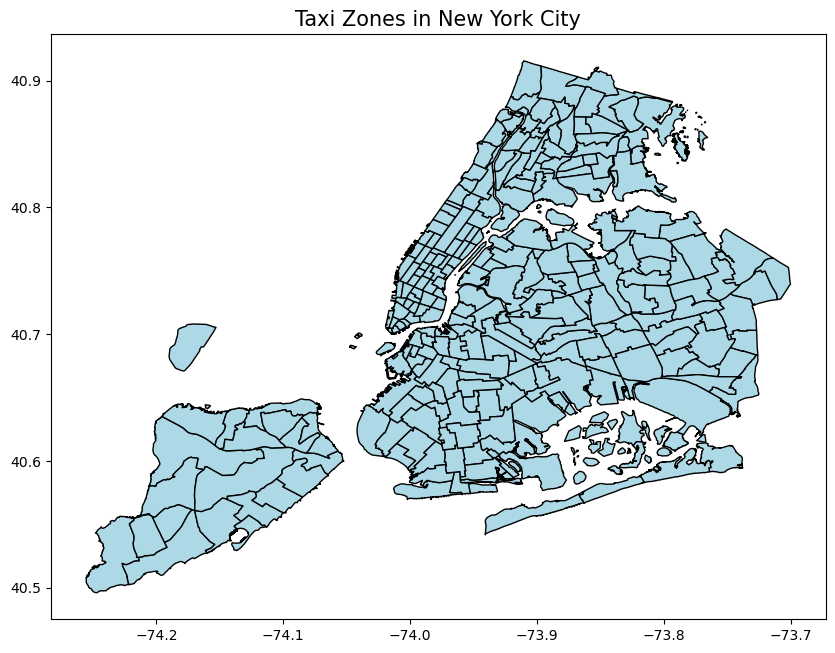

In [395]:
taxi_zones['geometry'] = taxi_zones['the_geom'].apply(loads)  # loads
gdf = gpd.GeoDataFrame(taxi_zones, geometry='geometry')  

#plot
fig, ax = plt.subplots(figsize=(10, 10))  
gdf.plot(ax=ax, color='lightblue', edgecolor='black')  

ax.set_title('Taxi Zones in New York City', fontsize=15)  
plt.show()

In [396]:
#dtype
print(TaxiRidership['DOLocationID'].dtype) 
print(taxi_zones['LocationID'].dtype) 

#DOLocationID to str
TaxiRidership['DOLocationID'] = TaxiRidership['DOLocationID'].astype(str)  

merged_data = TaxiRidership.merge(taxi_zones, left_on='DOLocationID', right_on='LocationID')

int64
object


In [397]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'])  
merged_data['DOW'] = merged_data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday  
total_ridership = merged_data.groupby(['DOW', 'zone'])['vehicle_count'].sum().reset_index()

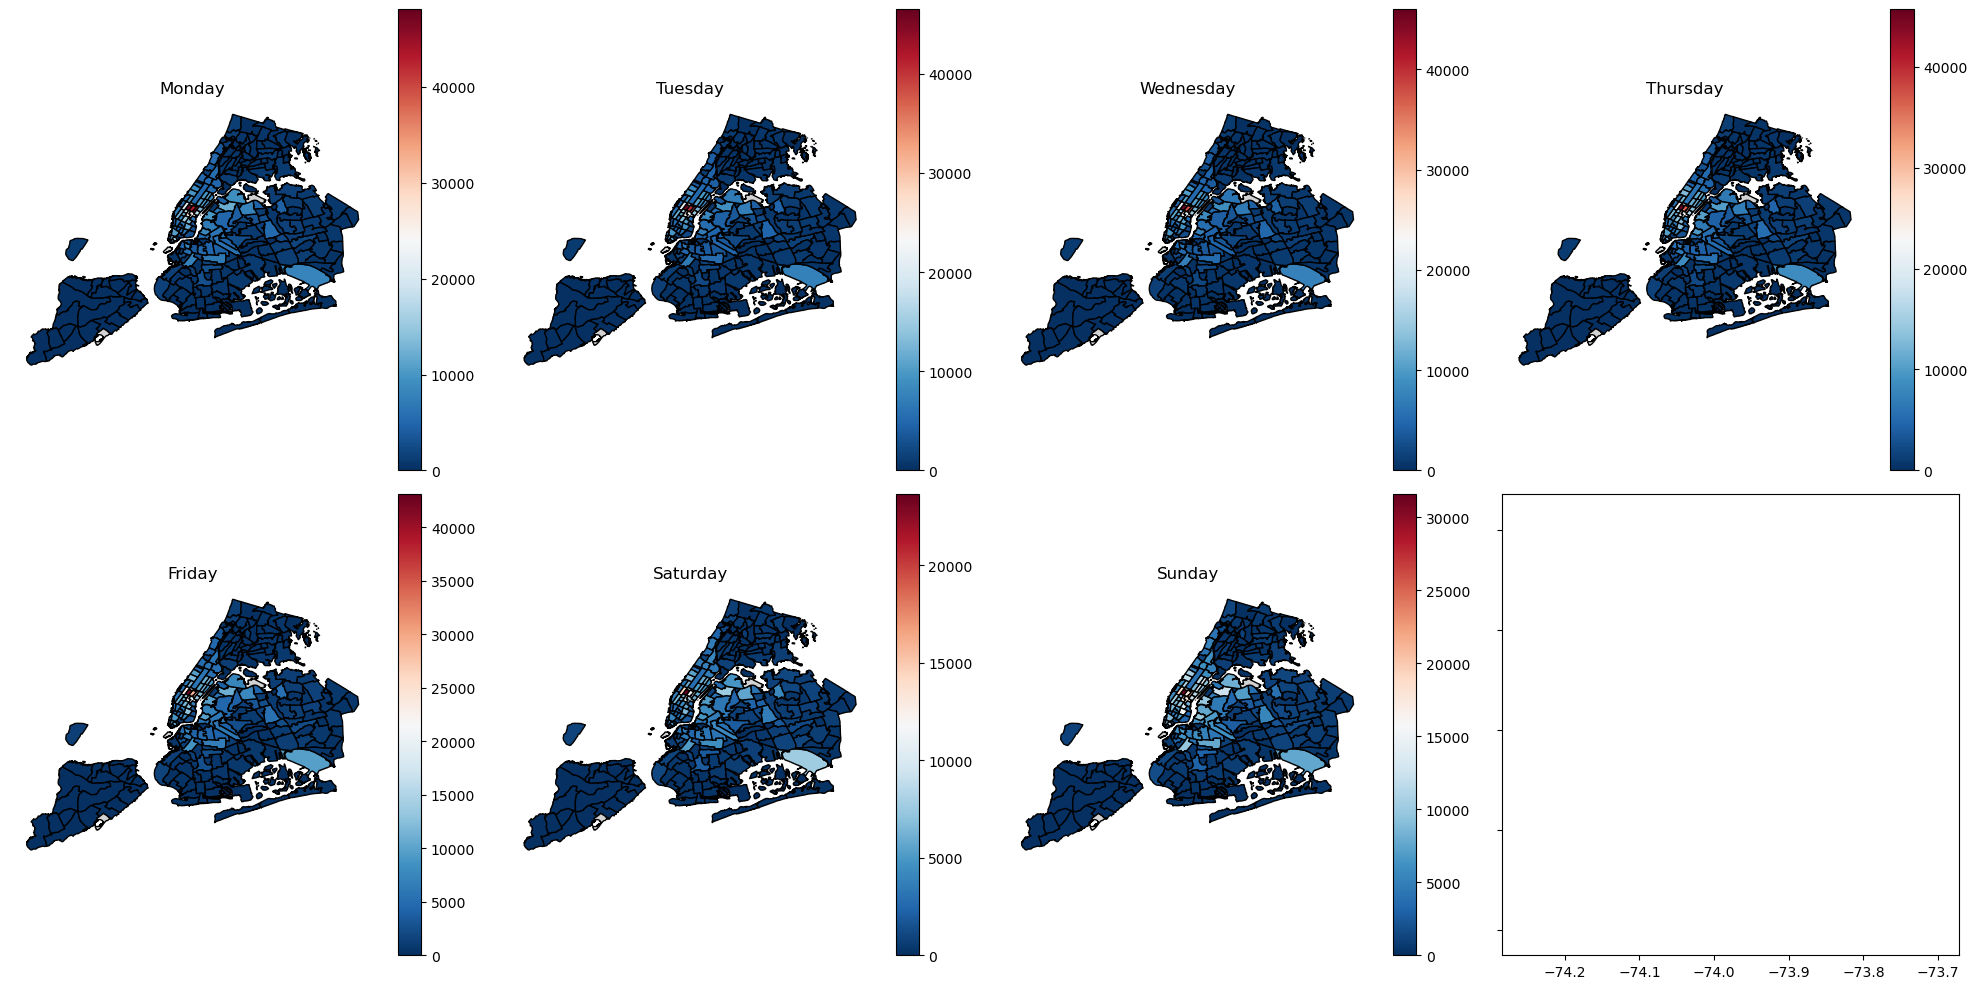

In [398]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)  
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  

for i in range(7):  
    ax = axes[i // 4, i % 4]  
    day_data = total_ridership[total_ridership['DOW'] == i]  
    
    day_geo_data = gdf.merge(day_data, left_on='zone', right_on='zone', how='left')  
    
    day_geo_data.plot(column='vehicle_count', ax=ax, legend=True,  
                      cmap='RdBu_r', edgecolor='black', missing_kwds={'color': 'lightgrey'})  
    
    ax.set_title(days[i])  
    ax.set_axis_off()  

plt.tight_layout()  
plt.show()

## Task 2: Data preprocessing (10pts)

### Q1. 将乘客量汇总到日期-小时级别（针对整个城市，所有下车地点的数据汇总），并与航班到达数据合并（5 分）

注意：日期-小时级别意味着你需要统计每天每个小时的乘客数量。

提示：在合并之前，可能需要对两个数据集进行格式预处理。


In [401]:
# example of taxi ridership date-hour level aggregation output

In [402]:
#create a date-hour column for TaxiRidership  
TaxiRidership['date_hour'] = TaxiRidership['Date'].dt.floor('H')  

#Group by date_hour and aggregate vehicle_count  
aggregated_ridership = TaxiRidership.groupby('date_hour')['vehicle_count'].sum().reset_index()  

#Prepare Flight Arrival data for merging  
#to date_hour  
FlightArrival['date_hour'] = FlightArrival['Date'].dt.floor('H')  

# Merge the aggregated ridership with flight arrivals on date_hour  
dataset = pd.merge(aggregated_ridership, FlightArrival, on='date_hour', how='left')  


### Q2. 添加时间滞后到达量（1,2,3,4,5,6..12小时前） - 5分

出租车和FHV（豪华轿车）乘客量受到航班到达的影响。直观来说，航班数量增加会带来更多乘客，从而提高乘客量。然而，小时乘客量不仅与同一小时到达的航班有关，1小时前、2小时前的到达也可能影响乘客量，因为旅客需要一些时间通过海关或等待行李。因此，请将`arrivals`的滞后值作为额外特征添加，并将新特征命名为`lag1`（表示1小时前的到达量）、`lag2`（表示2小时前的到达量），依此类推。你可以使用Pandas中的`shift`函数来添加到达滞后值。例如，df['arrivals'].shift(1)表示添加1小时的到达滞后值，`iloc`函数也可以实现同样的功能。


In [404]:
for lag in range(1, 13): 
    dataset[f'lag{lag}'] = dataset['arrivals'].shift(lag)  


In [405]:
# example of dataset after added 12 lag arrivals features
dataset.iloc[:20]

,date_hour,vehicle_count,Date,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,142.0,2018-01-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,23.0,2018-01-01 01:00:00,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,2.0,2018-01-01 02:00:00,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,1.0,2018-01-01 03:00:00,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,13.0,2018-01-01 04:00:00,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-01-01 05:00:00,13.0,2018-01-01 05:00:00,0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-01 06:00:00,15.0,2018-01-01 06:00:00,0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01 07:00:00,46.0,2018-01-01 07:00:00,5,0.0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
8,2018-01-01 08:00:00,248.0,2018-01-01 08:00:00,14,5.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN
9,2018-01-01 09:00:00,443.0,2018-01-01 09:00:00,15,14.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN


## Task 3. Data Exploration (20pts)


### 问题1（5分）。打印一些数据集特征：记录数，FHV和出租车行程的总数, 到达航班的总数据集。



In [408]:
num_records = dataset.shape[0]  
total_vehicle_count = dataset['vehicle_count'].sum()  
total_arrivals = dataset['arrivals'].sum()  

print("Number of records:", num_records)  
print("Total number of FHV and taxi trips:", total_vehicle_count)  
print("Total number of arriving flights:", total_arrivals)

Number of records: 8760
Total number of FHV and taxi trips: 5430922.0
Total number of arriving flights: 163713


。
### 问题2（10分）。绘制工作日和周末的小时乘车量的概率分布函数，并应用t检验来检查每个工作日与其他日子之间的小时乘车量是否存在显著差异，显著性水平为α=0.05。结果以一个7×1的表格报告，索引名称应为工作日（例如，星期一），值应为True或False（在P < 0.05时为True）。
提示：您可以使用`scipy.stats`中的`norm.pdf`函数来计算概率分布，首先进行个数据集。


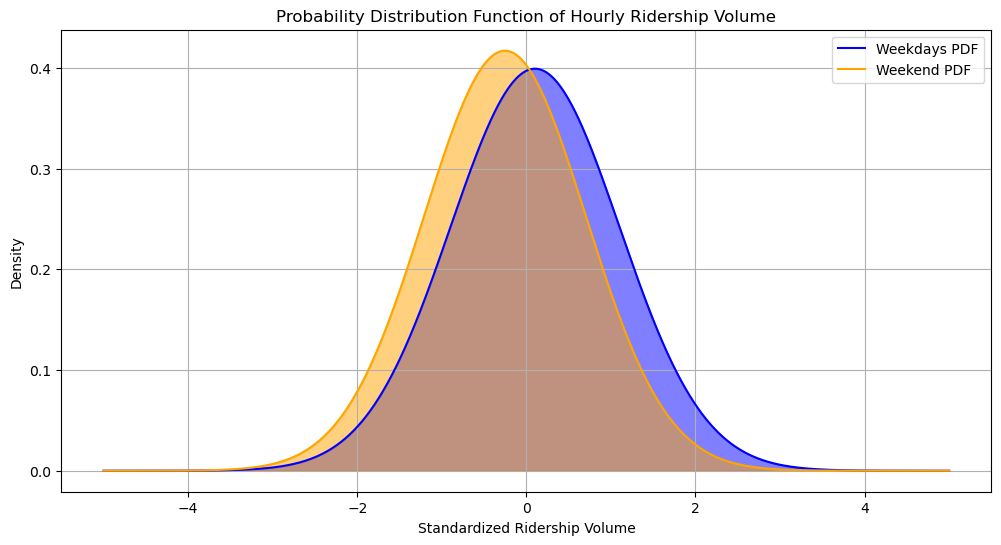

           Significant Difference
Monday                       True
Tuesday                      True
Wednesday                    True
Thursday                    False
Friday                      False
Saturday                     True
Sunday                       True


In [410]:
import pandas as pd  
import numpy as np  
from scipy import stats  
import matplotlib.pyplot as plt  
import seaborn as sns  

# Ensure date-time and DOW columns are created.
dataset['date_hour'] = pd.to_datetime(dataset['date_hour'])  
dataset['DOW'] = dataset['date_hour'].dt.dayofweek  # 0=mon，6=sun 

# Number of passengers on weekdays and weekends
weekdays = dataset[dataset['DOW'] < 5]['vehicle_count']  
weekend = dataset[dataset['DOW'] >= 5]['vehicle_count']  

# Standardized Passenger Count
dataset['standardized_vehicle_count'] = (dataset['vehicle_count'] - dataset['vehicle_count'].mean()) / dataset['vehicle_count'].std()  

# Extract the standardized passenger numbers for weekdays and weekends again.
standardized_weekdays = dataset[dataset['DOW'] < 5]['standardized_vehicle_count']  
standardized_weekend = dataset[dataset['DOW'] >= 5]['standardized_vehicle_count']  

# Calculate the mean and standard deviation
mean_weekdays = np.mean(standardized_weekdays)  
std_weekdays = np.std(standardized_weekdays)  
mean_weekend = np.mean(standardized_weekend)  
std_weekend = np.std(standardized_weekend)  

# Create x range for plotting PDF
x = np.linspace(-5, 5, 1000)  

# Probability Distribution Function for Working Days and Weekends
pdf_weekdays = stats.norm.pdf(x, mean_weekdays, std_weekdays)  
pdf_weekend = stats.norm.pdf(x, mean_weekend, std_weekend)  

# Draw Probability Distribution Function
plt.figure(figsize=(12, 6))  
plt.plot(x, pdf_weekdays, label='Weekdays PDF', color='blue')  
plt.plot(x, pdf_weekend, label='Weekend PDF', color='orange')  
plt.fill_between(x, pdf_weekdays, color='blue', alpha=0.5)  
plt.fill_between(x, pdf_weekend, color='orange', alpha=0.5)  
plt.title('Probability Distribution Function of Hourly Ridership Volume')  
plt.xlabel('Standardized Ridership Volume')  
plt.ylabel('Density')  
plt.legend()  
plt.grid()  
plt.show()  

# Conduct a t-test and examine the significant differences in passenger volume for each day compared to weekdays.
alpha = 0.05  
hypothesis_testing_result = {}  

for i in range(7):  # Iterate through each day of the week
    day_data = dataset[dataset['DOW'] == i]['standardized_vehicle_count']  
    
    # Calculate the t-test for working days and that day.
    t_stat_day, p_val_day = stats.ttest_ind(standardized_weekdays, day_data, nan_policy='omit')  
    hypothesis_testing_result[days[i]] = p_val_day < alpha  # P值小于显著性水平，返回True  

# Convert the results to a DataFrame
hypothesis_testing_result_df = pd.DataFrame(hypothesis_testing_result, index=['Significant Difference']).T  
print(hypothesis_testing_result_df)

化。

### 问题3（5分）。绘制乘车量最高的月份的`vehicle_count`和`arrivals`的时间线（整个月份的车辆计数总和）。由于`arrivals`和`vehicle_count`的尺度不同，因此首先标准化个数据集。


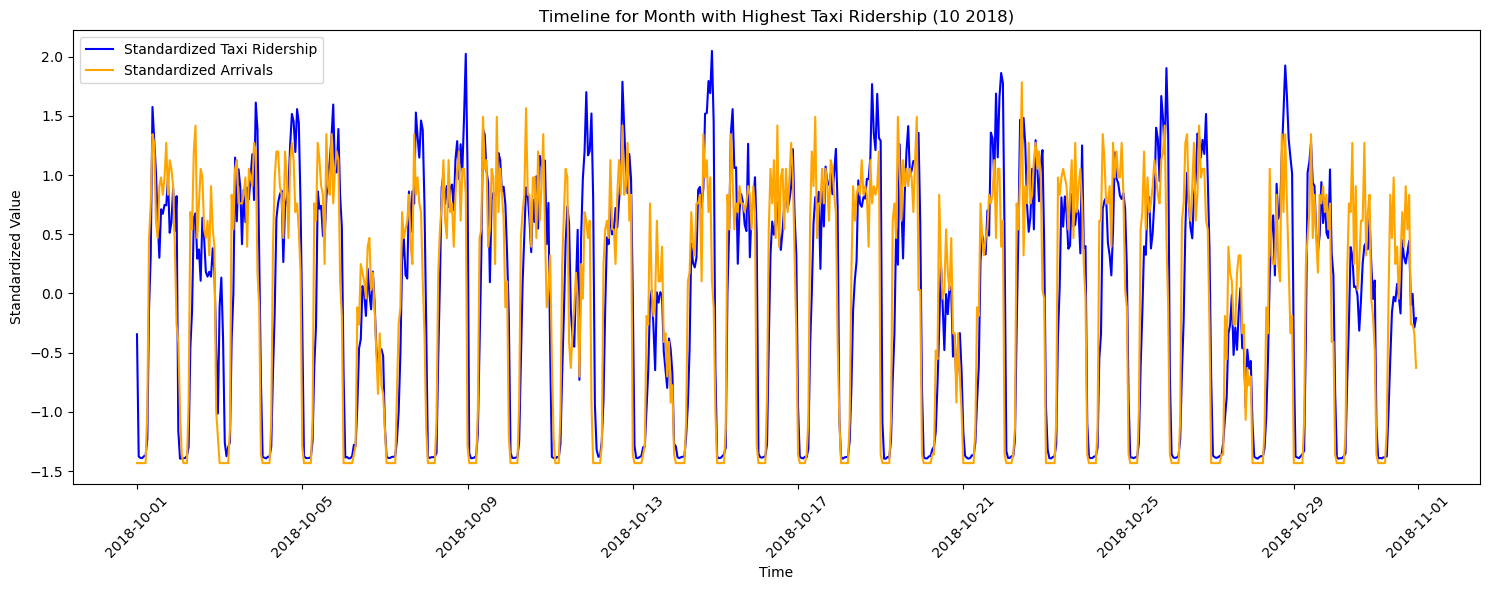

In [412]:
# Convert `date_hour` column to date format  
dataset['date'] = dataset['date_hour'].dt.date  

# Summarize the ridership per month  
monthly_ridership = dataset.groupby(dataset['date_hour'].dt.to_period('M')).agg({'vehicle_count':'sum', 'arrivals':'sum'}).reset_index()  

# Find the month with the highest ridership  
highest_month = monthly_ridership.loc[monthly_ridership['vehicle_count'].idxmax()]  

# Extract year and month  
highest_month_period = highest_month['date_hour']  
highest_month_year = highest_month_period.year  
highest_month_month = highest_month_period.month  

# Filter the data for that month  
highest_month_data = dataset[  
    (dataset['date_hour'].dt.year == highest_month_year) &   
    (dataset['date_hour'].dt.month == highest_month_month)  
].copy()  # Use .copy() to avoid SettingWithCopyWarning  

# Standardize the data for plotting  
highest_month_data.loc[:, 'standardized_vehicle_count'] = (highest_month_data['vehicle_count'] - highest_month_data['vehicle_count'].mean()) / highest_month_data['vehicle_count'].std()  
highest_month_data.loc[:, 'standardized_arrivals'] = (highest_month_data['arrivals'] - highest_month_data['arrivals'].mean()) / highest_month_data['arrivals'].std()  

# Create the plot  
plt.figure(figsize=(15, 6))  
plt.plot(highest_month_data['date_hour'], highest_month_data['standardized_vehicle_count'], label='Standardized Taxi Ridership', color='blue')  
plt.plot(highest_month_data['date_hour'], highest_month_data['standardized_arrivals'], label='Standardized Arrivals', color='orange')  

# Set titles and labels in English  
plt.title(f'Timeline for Month with Highest Taxi Ridership ({highest_month_month} {highest_month_year})')  
plt.xlabel('Time')  
plt.ylabel('Standardized Value')  
plt.legend()  
plt.xticks(rotation=45)  
plt.tight_layout()  

# Show the plot  
plt.show()

## 任务 4：构建 FHV 和出租车乘客数量与到达数据的线性回归模型（25 分 - 每个部分 5 分）最大化的 m。最终评估测试样本上的回归结果。



### 问题 1. 将数据分为训练、验证和测试样本
将前 90 天的数据用作训练集，接下来的 180 天作为验证集，最后的 90 天作为测试集。



In [415]:
train_data = dataset[(dataset['date_hour'] >= '2018-01-01') & (dataset['date_hour'] < '2018-04-01')].copy()  
val_data = dataset[(dataset['date_hour'] >= '2018-04-01') & (dataset['date_hour'] < '2018-10-01')].copy()  
test_data = dataset[(dataset['date_hour'] >= '2018-10-01')].copy()  

# Add hour and dow columns
train_data['hour'] = train_data['date_hour'].dt.hour  
train_data['dow'] = train_data['date_hour'].dt.dayofweek  

val_data['hour'] = val_data['date_hour'].dt.hour  
val_data['dow'] = val_data['date_hour'].dt.dayofweek  

# Ensure that test_data also has hour and dow columns.
test_data['hour'] = test_data['date_hour'].dt.hour  
test_data['dow'] = test_data['date_hour'].dt.dayofweek  

# Add lagged variables
for lag in range(1, 13):  
    train_data[f'lag{lag}'] = train_data['arrivals'].shift(lag)  

# Remove NaN values generated due to lag.
train_data.dropna(inplace=True)  
val_data.dropna(inplace=True)  # 确保在验证数据中也移除 NaN 值  

# Continue with OLS modeling
import statsmodels.formula.api as smf  # 确保导入正确  


### 问题 2. 构建 OLS 模型
使用 `arrivals` 作为唯一预测变量，构建一个带有截距的 OLS 模型（可以使用 `smf.ols`）来预测 `vehicle_count`。检查 `arrivals` 的 p 值，它表示什么？报告 `arrivals` 系数的 99% 置信区间。绘制乘客数量与航班到达之间的散点图，并包含预测线。


                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     5598.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:14:01   Log-Likelihood:                -14611.
No. Observations:                2148   AIC:                         2.923e+04
Df Residuals:                    2146   BIC:                         2.924e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.5501      7.823      9.785      0.0

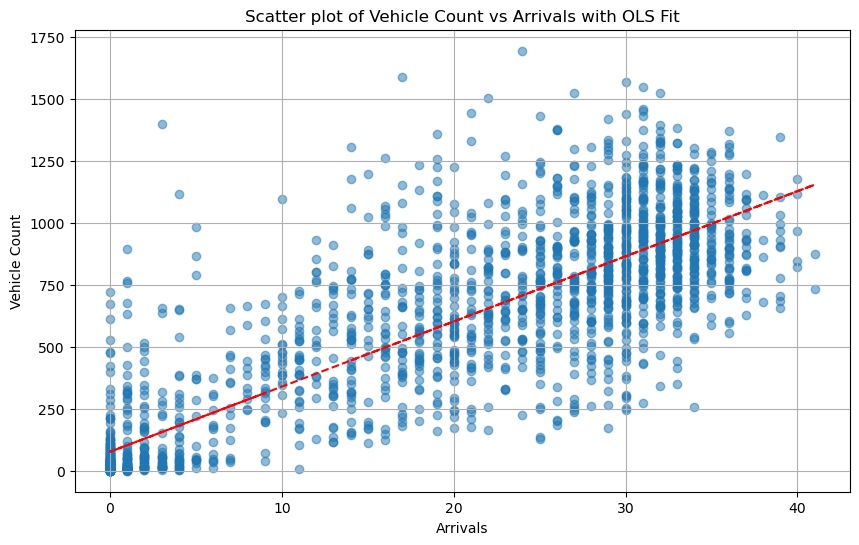

In [417]:
model_ols = smf.ols(formula='vehicle_count ~ arrivals', data=train_data).fit()  
print(model_ols.summary())  

# P-value interpretation  
p_value_arrivals = model_ols.pvalues['arrivals']  
if p_value_arrivals < 0.01:  
    print("The p-value for arrivals is less than 0.01, indicating a statistically significant relationship with vehicle_count.")  
else:  
    print("The p-value for arrivals is greater than 0.01, indicating a statistically insignificant relationship with vehicle_count.")  

# 99% confidence interval for arrivals' coefficient  
confidence_interval = model_ols.conf_int(alpha=0.01).loc['arrivals']  
print(f"99% confidence interval for arrivals' coefficient: {confidence_interval}")  

# Scatter plot for ridership and flight arrival with predictive line  
plt.figure(figsize=(10, 6))  
plt.scatter(train_data['arrivals'], train_data['vehicle_count'], alpha=0.5)  
plt.plot(train_data['arrivals'], model_ols.predict(), color='red', linestyle='--')  
plt.title('Scatter plot of Vehicle Count vs Arrivals with OLS Fit')  
plt.xlabel('Arrivals')  
plt.ylabel('Vehicle Count')  
plt.grid()  
plt.show()  


### 问题 3. 考虑到到达的即时历史影响
通过添加时间滞后变量来增加模型。添加所有 12 个滞后变量，并运行上述回归。  
航班到达与出发之间存在一定的延迟（例如，通关、取行李等）。`vehicle_count` 可能与航班到达的历史值（滞后）而非即时的 `arrivals` 更相关。创建一个公式，包括以下变量，并进行回归：
* arrival, lag1, ..., lagN：在 1 小时到 N=12 小时内发生的到达数量。  
根据 p 值来判断哪些变量具有统计显著影响。


In [419]:
# Adding all 12 lag variables into the regression  
for lag in range(1, 13):  
    train_data[f'lag{lag}'] = train_data['arrivals'].shift(lag)  

# Dropping NaN values created by shifting  
train_data = train_data.dropna()  

# Regression with arrivals and lag variables  
formula_with_lags = 'vehicle_count ~ arrivals + ' + ' + '.join([f'lag{lag}' for lag in range(1, 13)])  
lag_model = smf.ols(formula=formula_with_lags, data=train_data).fit()  
print(lag_model.summary())  

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1019.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:14:01   Log-Likelihood:                -13787.
No. Observations:                2136   AIC:                         2.760e+04
Df Residuals:                    2122   BIC:                         2.768e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.4790      9.512     -5.833      0.0


### 问题 4. 融入时间模式
添加周几和一天中的小时的分类变量。  
从任务 1 问题 3 的可视化中可以看出，出租车乘客人数和到达量都遵循一种周期性的时间模式。直观上，对于大多数交通流量来说这种情况是成立的，包括高峰时段，并且在一周内变化。通常，我们会添加虚拟/分类变量（布尔变量：1 表示真，0 表示假）来捕捉不同时间段人们出行模式的时段。

请注意，作为常规回归的小时和周几变量并不合适，因为我们无法预测它们的线性数值影响。相反，使用表达式 `C(.)` 或 `pd.get_dummies` 可以在回归公式中将这些变量视为分类变量，从而添加相应的虚拟变量以考虑其可能的离散值。

对 `vehicle_count` 乘客数量进行回归，使用 `arrivals`、滞后变量和时间分类变量作为自变量。


In [421]:
# Building the enhanced regression model  
enhanced_formula = formula_with_lags + ' + C(hour) + C(dow)'  
enhanced_model = smf.ols(formula=enhanced_formula, data=train_data).fit()  
print(enhanced_model.summary())  

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     450.5
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:14:01   Log-Likelihood:                -13438.
No. Observations:                2136   AIC:                         2.696e+04
Df Residuals:                    2093   BIC:                         2.720e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        52.0667     23.755      2.192


### 问题 5. 对滞后变量进行特征选择
由于并非所有滞后变量对回归模型都有统计显著的影响，因此有些变量可能并不相关。尝试使用循环训练包含 m 个最新到达量/滞后变量的回归模型，m=0, 1,...,12，并报告和绘制在验证样本上的样本外 R² 随 m 的变化，选择使 R² 最大化的 m。最终评估测试样本上的回归结果。


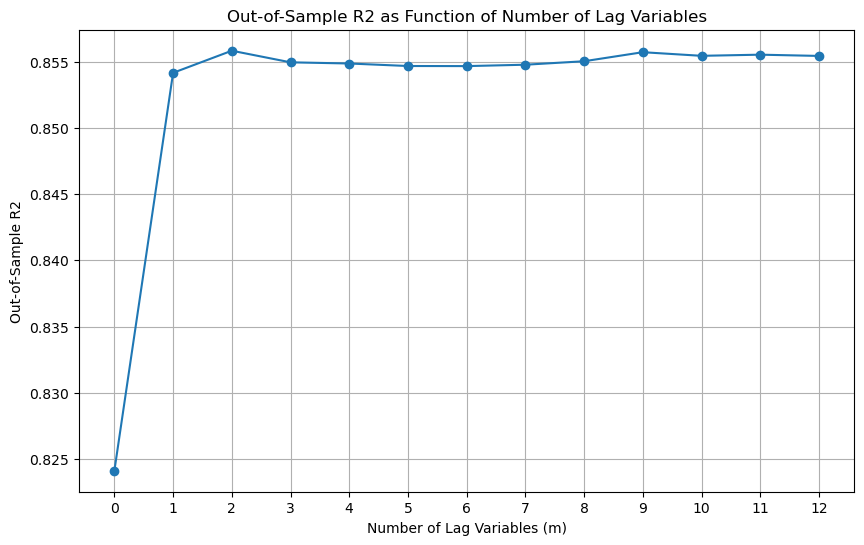

The best number of lag variables (m) maximizing the out-of-sample R2 is: 2
Final R-squared on test sample: 0.8557469711645914


In [423]:
out_of_sample_r2 = []  

# Loop through different amounts of lag variables (m = 0 to 12)  
for m in range(13):  # include m most recent arrival volumes/lags  
    if m == 0:  
        # Only use arrivals as predictor without any lag variables  
        formula_m = f'vehicle_count ~ arrivals + C(hour) + C(dow)'  
    else:  
        # Include the first m lag variables  
        formula_m = f'vehicle_count ~ arrivals + ' + ' + '.join([f'lag{lag}' for lag in range(1, m + 1)]) + ' + C(hour) + C(dow)'  
    
    # Fit the model  
    model_m = smf.ols(formula=formula_m, data=train_data).fit()  
    
    # Validate performance on out-of-sample data  
    val_predictions = model_m.predict(val_data)  
    
    # Calculate out-of-sample R2  
    r2_val = r2_score(val_data['vehicle_count'], val_predictions)  
    out_of_sample_r2.append(r2_val)  

# Plot out-of-sample R2 as a function of m  
plt.figure(figsize=(10, 6))  
plt.plot(range(13), out_of_sample_r2, marker='o')  
plt.title('Out-of-Sample R2 as Function of Number of Lag Variables')  
plt.xlabel('Number of Lag Variables (m)')  
plt.ylabel('Out-of-Sample R2')  
plt.xticks(range(13))  
plt.grid()  
plt.show()  

# Get the best m  
best_m = np.argmax(out_of_sample_r2)  
print(f"The best number of lag variables (m) maximizing the out-of-sample R2 is: {best_m}")  

# Evaluate the final regression over the test sample using the best m  
if best_m == 0:  
    final_formula = 'vehicle_count ~ arrivals + C(hour) + C(dow)'  
else:  
    final_formula = 'vehicle_count ~ arrivals + ' + ' + '.join([f'lag{lag}' for lag in range(1, best_m + 1)]) + ' + C(hour) + C(dow)'  

# 确保此处使用的数据具有 hour 和 dow 列  
final_model = smf.ols(formula=final_formula, data=pd.concat([train_data, val_data])).fit()  # Use both training and validation data  
test_predictions = final_model.predict(test_data)  

# Out-of-sample evaluation on test data  
final_r2_test = r2_score(test_data['vehicle_count'], test_predictions)  
print(f"Final R-squared on test sample: {final_r2_test}")


## 任务 5. 基于 FHV 和出租车从机场出发的相对时间线聚类一年中的日子（25 分


### 问题 1 (5 分)。从整个 `dataset`中创建一个数据框，行表示天，列表示小时，a) FHV，b) 每小时的出租车出发次数作为值（可以使用 `pd.pivot_table`）。按日均载客量对每行进行归一化。将表 a) 和 b) 横向合并。


In [428]:
TaxiRidership = pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/LGAVehicleByHour.csv")  
FlightArrival = pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/LGAFlightArrival.csv")  

#Convert the Date column of TaxiRidership to datetime format.
TaxiRidership['date_hour'] = pd.to_datetime(TaxiRidership['Date'])  

#Convert the Date column of FlightArrival to datetime format.
FlightArrival['date_hour'] = pd.to_datetime(FlightArrival['Date'], format='%y/%m/%d %H:%M')  

#Extract hours from Taxi Ridership
TaxiRidership['hour'] = TaxiRidership['date_hour'].dt.hour  

# Extract hours from Flight Arrival
FlightArrival['hour'] = FlightArrival['date_hour'].dt.hour  

#Number of passengers for FHV and taxis (per hour)
traffic_data = TaxiRidership.groupby(['date_hour', 'hour'])['vehicle_count'].sum().reset_index()  

#Aggregate the data on flight arrivals.
flights_data = FlightArrival.groupby(['date_hour', 'hour'])['arrivals'].sum().reset_index()  

#Standardize column names
flights_data.columns = ['date_hour', 'hour', 'arrivals']  

#Merge Data
merged_data = pd.merge(traffic_data, flights_data, on=['date_hour', 'hour'], how='outer')  

#Create total passenger series
merged_data['total_passengers'] = merged_data['vehicle_count'].fillna(0) + merged_data['arrivals'].fillna(0)  

# Reshape the DataFrame with date and hour as the index, and then perform normalization.
merged_data['date'] = merged_data['date_hour'].dt.date  
hourly_passenger_counts = merged_data.pivot_table(index='date', columns='hour', values='total_passengers', aggfunc='sum')  

# Normalization
normalized_hourly_counts = hourly_passenger_counts.div(hourly_passenger_counts.sum(axis=1), axis=0)  

print(normalized_hourly_counts.head())

hour              0         1         2         3         4         5   \
date                                                                     
2018-01-01  0.011260  0.001786  0.000233  0.000078  0.001010  0.001010   
2018-01-02  0.051992  0.003396  0.001829  0.000131  0.000327  0.001045   
2018-01-03  0.054189  0.024843  0.001930  0.000241  0.000643  0.000965   
2018-01-04  0.249791  0.010025  0.001671  0.000835  0.008354  0.012531   
2018-01-05  0.033091  0.013929  0.002448  0.001266  0.000675  0.001266   

hour              6         7         8         9   ...        14        15  \
date                                                ...                       
2018-01-01  0.001165  0.003961  0.020346  0.035567  ...  0.061350  0.068727   
2018-01-02  0.001633  0.020509  0.037296  0.074657  ...  0.059830  0.044024   
2018-01-03  0.003779  0.015195  0.044863  0.064721  ...  0.058289  0.057164   
2018-01-04  0.035923  0.025898  0.026734  0.024227  ...  0.056809  0.066834   
2018-01


### 问题 2 (10 分)。尝试对不同数量的聚类 k=2..7 进行 K-means 聚类，报告每个聚类的平均轮廓系数。哪一个 k 从轮廓系数的角度看是“最佳”？


In [430]:
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score  

# Data to be clustered
data_to_cluster = normalized_hourly_counts.fillna(0)  

#K value range
k_range = range(2, 8)  
silhouette_scores = []  

for k in k_range:  
    kmeans = KMeans(n_clusters=k, random_state=42)  
    cluster_labels = kmeans.fit_predict(data_to_cluster)  
    score = silhouette_score(data_to_cluster, cluster_labels)  
    silhouette_scores.append(score)  
    print(f'K={k}, Average silhouette coefficient={score:.4f}')  

#Determine the optimal k value
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]  
print(f'Optimal number of clusters K = {best_k}')

K=2, 平均轮廓系数=0.1902
K=3, 平均轮廓系数=0.2255


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=4, 平均轮廓系数=0.1521
K=5, 平均轮廓系数=0.1739
K=6, 平均轮廓系数=0.1829


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=7, 平均轮廓系数=0.1823
最佳聚类数 K = 3



### 问题 3 (5 分)。使用上面得到的最佳 k 进行 K-means 聚类。报告每个聚类中一周每一天的出现次数。你如何根据这些结果解释聚类？  
提示：创建一个字典，将聚类编号与每年的每一天相对应，应用此字典添加一列“cluster”到数据框中，并使用透视表和聚合函数`count`来汇总上述数字。


In [432]:
import os  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score  

#Set environment variables to prevent KMeans from leaking memory on Windows.
os.environ["OMP_NUM_THREADS"] = "2"  

#  Using the optimal k for K-means clustering
kmeans_best = KMeans(n_clusters=best_k, random_state=42)  
best_cluster_labels = kmeans_best.fit_predict(data_to_cluster)  

# Add the clustering results to normalized_hourly_counts.
normalized_hourly_counts['cluster'] = best_cluster_labels  

# Count the occurrences of each day of the week in each cluster.
weekly_day_counts = {}  

# Cluster individually and count the number of each day of the week in each cluster.
for cluster in range(best_k):  
    # Find all the dates belonging to the current cluster.
    cluster_data = normalized_hourly_counts[normalized_hourly_counts['cluster'] == cluster]  
    
    # Get the date from the index
    weekdays = pd.to_datetime(cluster_data.index).dayofweek  
    
    # Count the occurrences of each day of the week.
    weekday_counts = pd.Series(weekdays).value_counts() 
    weekly_day_counts[cluster] = weekday_counts  

print("Number of occurrences of each day of the week in each cluster：")  
for cluster, counts in weekly_day_counts.items():  
    print(f"Cluster {cluster} - Day of the Week Counts:")  
    print(counts)  


Number of occurrences of each day of the week in each cluster：
Cluster 0 - Day of the Week Counts:
date
1    41
2    41
0    37
4    37
3    36
5     7
6     3
Name: count, dtype: int64
Cluster 1 - Day of the Week Counts:
date
5    45
4    11
0     9
1     8
2     7
3     5
Name: count, dtype: int64
Cluster 2 - Day of the Week Counts:
date
6    49
3    11
0     7
4     4
2     4
1     3
Name: count, dtype: int64


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



### 问题 4 (5 分)。可视化每个聚类的小时时间线，并按聚类中的总载客量进行归一化。  
提示：使用透视表收集每个聚类每天每小时的总乘客，并进行适当的归一化，以便可视化。


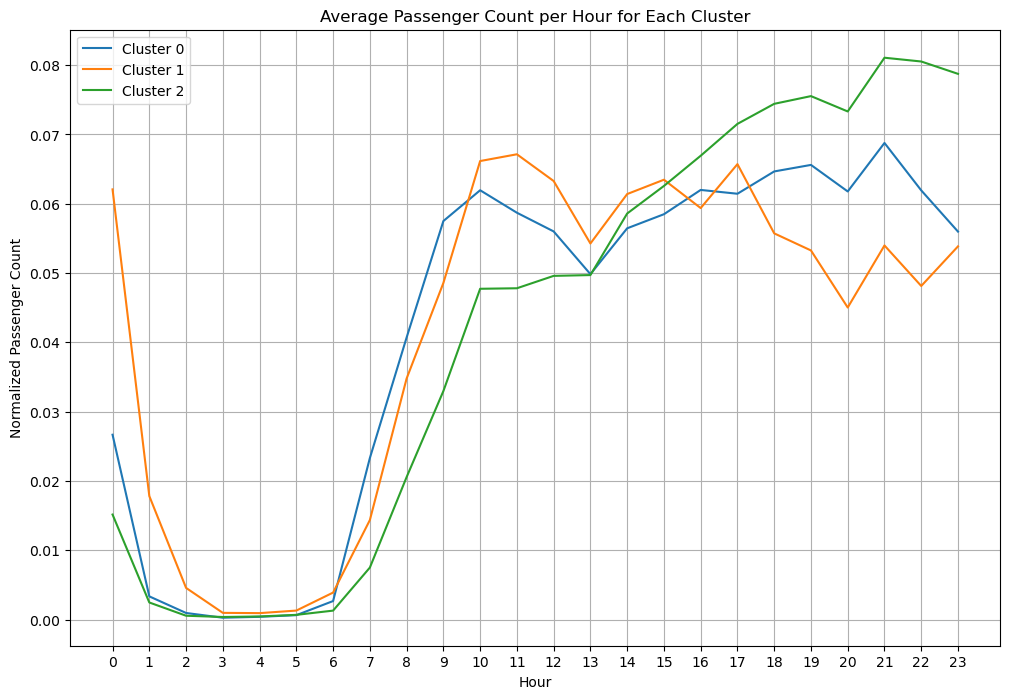

In [434]:
# Visualize the hourly timeline of each cluster.
plt.figure(figsize=(12, 8))  
for cluster in range(best_k):  
    cluster_data = normalized_hourly_counts[normalized_hourly_counts['cluster'] == cluster].mean().iloc[:-1] 
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}')  

plt.title("Average Passenger Count per Hour for Each Cluster")  
plt.xlabel("Hour")  
plt.ylabel("Normalized Passenger Count")  
plt.xticks(range(24), [f'{h}' for h in range(24)]) 
plt.legend()  
plt.grid()  
plt.show()